# Bayesian Causal Inference in Non-Randomized Experiments

**Author**: Leo Guelman

* [1. Problem Statment](#problem1)
 * [1.1 The National Study of Learning Mindsets](#mindsets11)
 * [1.2 Data Description](#data12)
 * [1.2 The Questions](#questions13)
* [2. Analysis](#analysis2) 
 * [2.1 Imports](#imports21)
 * [2.2 Data](#data22)
 * [2.3 Assessing Balance of Covariates](#balance23)
 * [2.4 Propensity score](#propscore24)
 * [2.5 Model-based Inference](#mbinference25)
 
 

* [References](#ref)
 
 


# 1. Problem Statment <a class="anchor" id="problem1"></a>

## 1.1 The National Study of Learning Mindsets <a class="anchor" id="mindsets11"></a>

We look at the causal inference challenge presented by the *National Study of Learning Mindsets* (Yeager et al., 2019) from a Bayesian perspective. 

The NSLM is a randomized experiment designed to assess the effectiveness of an intervention to improve academic outcomes of students with a *growth mindset*. The *growth mindset* is a belief that people can develop intelligence, as opposed to the *fixed mindset* view which sees intelligence as an innate trait that is fixed at birth.

The original study consisted in a randomized experiment composed of students from 76 schools drawn from the national probability sample of U.S. public schools. In addition, to assessing the average treatment effect (ATE), the study was designed to estimate the degree of heterogeneity in treatment effect across both students and schools. 

A synthetic dataset was generated to mimic the original data, but with the goal of creating an observational study that includes confounding effects not present in the original randomized experiment. Besides this difference, the synthetic data resembles the real NSLM data in terms of covariate distribution, data structures, and effect sizes. 

During the 2018 Atlantic Causal Inference Conference, eight groups of participans were invited to analyze the synthetic data to assess the questions of average treatment effect and treatment effect variation in non-randomized experimental settings. Participants employed a diverse set of methods, ranging from matching and flexible outcome modeling to semiparametric estimation and ensemble approaches. In this study, we employ an alternative approach founded in Bayesian inference principles.

## 1.2 Data Description <a class="anchor" id="data12"></a>

The analysis is based on the sythetic dataset of $n=10,391$ children from a sample of $J=76$ schools. For each children $i=\{1, \ldots, n\}$, we observe a binary treatment indicator $Z_i$, a real-valued outcome $Y_i$, as well as 10 categorical or real-valued covariates as outlined in the table below. For a full description of the data generating process refer to Carvalho et al., 2019.


| Covariate | Description |
| :---        |    :----   | 
| S3 | Student’s self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment|
| C1 | Categorical variable for student race/ethnicity |
|C2 | Categorical variable for student identified gender
|C3 | Categorical variable for student first-generation status, i.e. first in family to go to college
|XC | School-level categorical variable for urbanicity of the school, i.e. rural, suburban, etc.
| X1 | School-level mean of students’ fixed mindsets, reported prior to random assignment
| X2|  School achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students
|X3  | School racial/ethnic minority composition, i.e., percentage of student body that is Black, Latino, or Native American
| X4 | School poverty concentration, i.e., percentage of students who are from families whose incomes fall below the federal poverty line
| X5 | School size, i.e., total number of students in all four grade levels in the school
| Y | Post-treatment outcome, a continuous measure of achievement
|Z | Treatment, i.e., receipt of the intervention





## 1.3 The Questions <a class="anchor" id="questions13"></a>

The two questions we are aiming to address as part of this study are the following:

1. Was the mindset intervention effective in improving student achievement?
2. Was the effect of the intervention moderated by school level achievement (X2) or pre-existing mindset norms (X1)? In particular there are two competing hypotheses about how X2 moderates the effect of the intervention: Either it is largest in middle-achieving schools (a "Goldilocks effect") or is decreasing in school-level achievement.


# 2. Analysis <a class="anchor" id="analysis2"></a>

## 2.1 Imports <a class="anchor" id="imports21"></a>

In [1]:
import os
os.chdir('/Users/lguelman/Library/Mobile Documents/com~apple~CloudDocs/LG_Files/Development/BCI/python')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
parameters = {'figure.figsize': (8, 4),
              'font.size': 8, 
              'axes.labelsize': 12}
plt.rcParams.update(parameters)
plt.style.use('fivethirtyeight')

import pystan
import multiprocessing
import stan_utility
import arviz as az

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier


import seaborn as sns

from acic_utils import pre_process_data, stan_model_summary

## 2.2 Data  <a class="anchor" id="data22"></a>

In [2]:
df = pd.read_csv("../data/synthetic_data.csv")
df
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10391 entries, 0 to 10390
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   schoolid  10391 non-null  int64  
 1   Z         10391 non-null  int64  
 2   Y         10391 non-null  float64
 3   S3        10391 non-null  int64  
 4   C1        10391 non-null  int64  
 5   C2        10391 non-null  int64  
 6   C3        10391 non-null  int64  
 7   XC        10391 non-null  int64  
 8   X1        10391 non-null  float64
 9   X2        10391 non-null  float64
 10  X3        10391 non-null  float64
 11  X4        10391 non-null  float64
 12  X5        10391 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 1.0 MB


,schoolid,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
count,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000,10391.000000
mean,39.888846,0.325666,-0.096742,5.268117,5.223078,1.489943,0.630931,2.447791,-0.040457,0.054841,-0.089349,-0.045911,-0.026168
std,24.008975,0.468646,0.643009,1.120765,3.982963,0.499923,0.482576,1.378420,0.969743,0.935560,0.962804,0.967262,1.010387
min,1.000000,0.000000,-2.097420,1.000000,1.000000,1.000000,0.000000,0.000000,-3.088790,-3.347819,-1.575463,-1.924778,-1.805073
25%,19.000000,0.000000,-0.548980,5.000000,3.000000,1.000000,0.000000,1.000000,-0.617888,-0.544506,-0.963095,-0.813799,-0.857026
50%,41.000000,0.000000,-0.118923,5.000000,4.000000,1.000000,1.000000,2.000000,-0.009954,-0.022514,-0.057036,-0.159602,-0.211553
75%,62.000000,1.000000,0.335663,6.000000,5.000000,2.000000,1.000000,4.000000,0.420441,0.726836,0.515392,0.596474,0.847844
max,76.000000,1.000000,2.194709,7.000000,15.000000,2.000000,1.000000,4.000000,2.834589,2.171815,2.358274,2.821660,1.892348


## 2.3 Assessing Balance of Covariates <a class="anchor" id="balance23"></a>

Covariate balance is the degree to which the distribution of covariates is similar across levels of the treatment. Here we assess the extent to which the treatment assignment was uniformly randomized across observational units, or there are some selection effects. To that end, we use *Prognostic scores* (Hansen 2008). The prognostic score is defined as the predicted outcome under the control condition, reflecting the baseline "risk", i.e., $E(Y|X, Z=0)$. It is estimated by fitting a model of the outcome in the control group, and then using that model to obtain predictions of the outcome under the control condition for all individuals. The standardize difference in the mean prognostic scores between treatment and control groups is used as a measure of covariate balance. 

Here we fit a Bayesian linear regression model to get a posterior distribution of the standardize difference in the mean prognostic scores between treatment and control groups.

We first pre-process the data (encode categorical features and scaling).

In [3]:
X, z, y, *_ = pre_process_data(df, standardize_x=True, interactions=False, 
                               p_score=None, drop_first=False)

print("Features dimension:", X.shape)
print("Treatment dimension:", z.shape)
print("Response dimension:", y.shape)
print("Number of treated / control units:", sum(z), "/", X.shape[0]-sum(z))

Features dimension: (10391, 28)
Treatment dimension: (10391,)
Response dimension: (10391,)
Number of treated / control units: 3384 / 7007


We now fit the model in [stan](https://mc-stan.org/). We place the stan code separately in `stan_linear_reg.stan`, stored in the repo.

In [4]:
n, p = X[z==0,:].shape # Fit model using control units only

stan_data_dict = {'N': n,
                  'K': p,
                  'x': X[z==0,:],
                  'y': y[z==0],
                  'N_new': X.shape[0],
                  'x_new': X
                  }

sm = pystan.StanModel('../stan/stan_linear_reg.stan') 
multiprocessing.set_start_method("fork", force=True)
fit = sm.sampling(data=stan_data_dict, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8096660a52168d4061eab351075ddfd3 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [5]:
fit_summary = stan_model_summary(fit)
fit_summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,-0.181427,0.000665,0.006414,-0.194224,-0.185570,-0.181424,-0.177214,-0.168535,93.115118,1.016513
beta[1],0.260977,0.000632,0.006375,0.248169,0.256472,0.261180,0.265417,0.273112,101.634249,1.030773
beta[2],-0.083988,0.000713,0.006470,-0.095836,-0.088558,-0.083732,-0.079942,-0.070550,82.458783,1.033549
beta[3],-0.047313,0.001042,0.007189,-0.060690,-0.052673,-0.047326,-0.042052,-0.033107,47.598150,1.053624
beta[4],-0.067084,0.001344,0.008490,-0.083448,-0.073415,-0.066859,-0.061357,-0.050089,39.925144,1.131900
...,...,...,...,...,...,...,...,...,...,...
prog_scores[10388],0.178159,0.011822,0.535489,-0.819092,-0.191524,0.169045,0.533726,1.269075,2051.617869,0.999552
prog_scores[10389],-0.637163,0.011632,0.530500,-1.624341,-1.010623,-0.633280,-0.269886,0.395488,2080.087794,0.999268
prog_scores[10390],-0.086881,0.011901,0.534869,-1.119410,-0.450691,-0.096604,0.273152,0.990936,2019.862337,0.999835
prog_scores[10391],-0.160116,0.011713,0.525359,-1.237784,-0.474761,-0.158841,0.187380,0.876885,2011.618090,0.999560


The standardize mean difference in Prognostic scores is positive meaning that students with highest potential outcomes under control are more likely to receive treatment. This can also be appreciated by plotting the proportion of individuals assigned to treatment for by quantile of the prognostic score (each quantile comprises about 1/5 of the observations). In this case, we say that the treatment assignment mechanisms is *counfounded* with the potential outcomes (i.e., the value of the outcome for each subject under each treatment, only one of which is observed).

In this context, a simple comparison of treated versus control individuals would produce bias estimates of treatment effects (both average and conditional effects). We thus proceed the analysis as an observational study instead on a randomized one. Specifically, to address this problem we directly incorporate an estimate of the *propensity score* in the specification of the outcome model, implicitly inducing a covariate dependent prior on the regression function (see Hahn 2020).




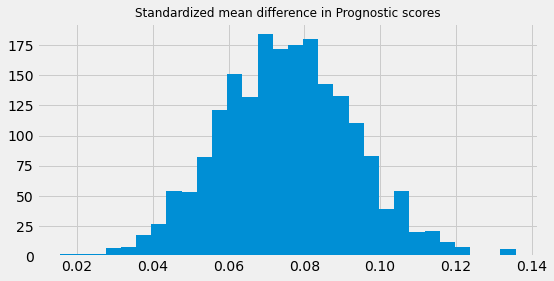

In [6]:
# Extract prognostic scores
samples = fit.extract(permuted=True)
prog_scores = samples['prog_scores'].T

# Compute mean and standardize mean differences in scores
mcmc_samples = prog_scores.shape[1]
prog_scores_diff = np.zeros(mcmc_samples)
prog_scores_std_diff = np.zeros(mcmc_samples)

for s in range(mcmc_samples):
    prog_scores_diff[s] = np.mean(prog_scores[z==1,s]) - np.mean(prog_scores[z==0,s])
    prog_scores_std_diff[s] = prog_scores_diff[s] / np.std(prog_scores[:,s])
  
                               
plt.hist(prog_scores_std_diff, bins = 30)
plt.title("Standardized mean difference in Prognostic scores", fontsize=12)
plt.show()  


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


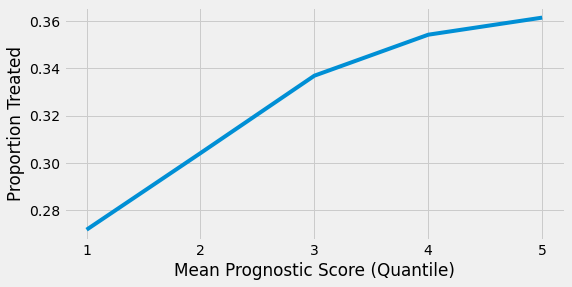

In [7]:
# Compute proportion treated by mean prognostic score quantile
prog_scores_df = pd.DataFrame({'prog_score_mean': np.mean(prog_scores, axis =1),'z':z})
prog_scores_df['prog_score_mean_quantile']= pd.qcut(prog_scores_df['prog_score_mean'], 
                                                    q = 5, labels = False)+1
prog_scores_df.groupby(['prog_score_mean_quantile'])['z'].mean().plot(xticks=list(range(1,6)), 
                                                                     xlabel='Mean Prognostic Score (Quantile)',
                                                                     ylabel='Proportion Treated')

## 2.4 Propensity Score <a class="anchor" id="propscore24"></a>

The propensity score is the probability of treatment assignment conditional on observed baseline covariates, i.e., $E(Z|X)$. Here we fit the propensity score using a flexible non-linear specification based on a Gradient Boosting method. Parameter tuning is done via cross-validated random search.

In [8]:
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

n_folds = 3
param_n_picks = 30

xgb = XGBClassifier(learning_rate=0.01, n_estimators=500, objective='binary:logistic',
                    silent=True, nthread=1)

skf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 42)

xgb_fits = RandomizedSearchCV(xgb, param_distributions=param_grid,
                              n_iter=param_n_picks, scoring='roc_auc', n_jobs=-1, 
                              cv=skf.split(X,z), verbose=3, random_state=42)

xgb_fits.fit(X, z)

print('\n Best estimator:')
print(xgb_fits.best_estimator_)
print('\n Best AUC score:')
print(xgb_fits.best_score_)
print('\n Best hyperparameters:')
print(xgb_fits.best_params_)

# We now fit the best estimator to all train data 
best_fit = xgb_fits.best_estimator_.fit(X, z)
pscore = best_fit.predict_proba(X)[:,1]
log_odds_pscore = np.log(pscore /(1-pscore))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished
/Users/lguelman/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:47:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:47:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=10, missing=nan, monotone_constraints

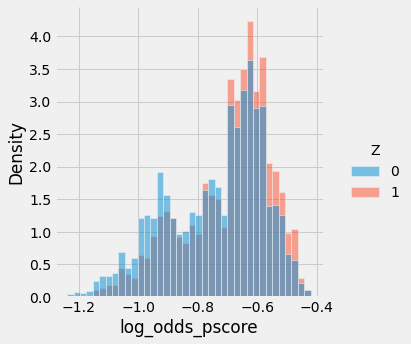

In [9]:
prop_score_df = pd.DataFrame({'log_odds_pscore': log_odds_pscore, 'Z':z})
sns.displot(prop_score_df, x="log_odds_pscore", 
            hue="Z",  stat="density", common_norm=False)

## 2.5 Model-based Inference <a class="anchor" id="mbinference25"></a>


We implement the Bayesian inference framework for causal effects introduced by Rubin (1978). In this framework, each observational unit $i=\{1,\ldots, N\}$ is seen as having a potential outcome for each level of treatment. In the binary treatment case with $Z \in [0,1]$, $Y_i(1)$ and $Y_i(0)$ represent the potential outcomes of unit $i$ under $Z=1$ and 
$Z=0$, respectively. Causal inference is considered a missing data problem since both potential outcomes are never jointly observed. Specifically, observed and missing outcomes can be expressed in terms of the potential outcomes as follows:

\begin{align*} 
Y_i^{\text{obs}} &=  Y_i(1)Z_i + Y_i(0)(1-Z_i) \\ 
Y_i^{\text{mis}} &=  Y_i(1)(1-Z_i) + Y_i(0)Z_i
\end{align*}


From a Bayesian perspective, $Y_i^{\text{mis}}$ is seen as a latent variable, similar to any other latent variable in the model (i.e., model parameters, using a frequentist language). The missing potential outcomes can be imputed by estimating the posterior distribution of the missing potential outcomes, conditioned on the observed quantities. That is,

$$
\text{Pr}(Y^{\text{mis}}| Y^{\text{obs}},Z, X).
$$

Estimating the above quantity, requires building a model of the joint distribution of potential outcomes. We assume that the true underlying model for the potential outcomes follows a bivariate Gaussian 

$$
\begin{pmatrix}
Y_i(0) \\
Y_i(1) 
\end{pmatrix} \bigg\lvert~X_i, \theta \sim N \left(\begin{pmatrix}
\alpha + X_i\beta_c \\
\alpha + X_i\beta_t + \tau
\end{pmatrix},\begin{pmatrix}
\sigma_c^{2} & \rho\sigma_c\sigma_t \\
\rho\sigma_c\sigma_t & \sigma_t^{2}
\end{pmatrix}\right),
$$

where $\theta=(\alpha, \beta_c, \beta_t, \tau, \sigma_c^2, \sigma_t^2, \rho)$.

A few observations from the model above:

* Since $Y_i(0)$ and $Y_i(1)$ are never jointly observed, we the $\rho$ cannot be estimated empirically, so it must be based on subject-matter knowledge. In practice, ....

* We allow for heterogeneous treatment effects - i.e., we define two different vectors $\beta_c$ and  $\beta_t$, for control and treated units, respectively. In the **Stan** model below, we allow for this heterogeneity by including interaction terms between each covariate and the treatment. The posterior estimates on the interaction effects represent the incremental effect of the treatment $\beta_t - \beta_c$

* The propensity score is considered as an additional covariate in $X$.


From this model, we can derive the conditional distribution of each potential outcome as


\begin{align*} 
\text{Pr}(Y_i(1) | Y_i(0), \theta, Z_i=0) &\sim N \Big(\mu_t+ \rho \frac{\sigma_t}{\sigma_c} (Y_i(0)-\mu_c), \sigma^2_t(1-\rho^2)\Big),\\
\text{Pr}(Y_i(0) | Y_i(1), \theta, Z_i=1) &\sim N \Big(\mu_c+ \rho \frac{\sigma_c}{\sigma_t} (Y_i(1)-\mu_t), \sigma^2_c(1-\rho^2)\Big), 
\end{align*}

where $\mu_c = \alpha + X\beta_c$ and $\mu_t = \alpha + X\beta_t + \tau$.

In [10]:
X, z, y, a_effects, m_effects, i_effects = pre_process_data(df, standardize_x=True, interactions=True, 
                                                            p_score=log_odds_pscore, drop_first=False)

# Get indexes of main and interaction effects
idx_m_effects = [a_effects.index(i) for i in m_effects]
idx_i_effects = [a_effects.index(i) for i in i_effects]

print(X.shape)
print(len(idx_m_effects))
print(len(idx_i_effects))
print(X[:,idx_m_effects].shape)
print(X[:,idx_i_effects].shape)

(10391, 58)
29
29
(10391, 29)
(10391, 29)


In [15]:
stan_data_mbi = {'N': X.shape[0], 
                 'N_main_cov':len(idx_m_effects),
                 'N_inter_cov':len(idx_i_effects),
                 'y': y,
                 'z': z,
                 'x': X[:,idx_m_effects],
                 'xz_inter': X[:,idx_i_effects],
                 'rho':0.0}

sm = pystan.StanModel('../stan/stan_mbi.stan') 
multiprocessing.set_start_method("fork", force=True)
fit_mbi = sm.sampling(data=stan_data_mbi, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_60991e207af6827951ca148d0742491d NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### 2.5.1 MCMC Diagnostics 

In [16]:
summary_stan_fit = stan_model_summary(fit_mbi)
summary_stan_fit

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,-0.133245,0.348577,1.413610,-2.447673,-1.101725,-0.312986,0.649372,3.024315,16.446097,1.295428
beta[1],0.224531,0.001051,0.010282,0.202714,0.217668,0.224487,0.231670,0.243813,95.797723,1.016815
beta[2],-0.073509,0.000556,0.007177,-0.087189,-0.078461,-0.073552,-0.068815,-0.058531,166.303376,1.025884
beta[3],-0.029722,0.000703,0.007811,-0.046009,-0.034671,-0.029283,-0.024600,-0.014645,123.348223,1.029926
beta[4],-0.045365,0.000959,0.010036,-0.064742,-0.052280,-0.045152,-0.038455,-0.025997,109.544643,1.022269
...,...,...,...,...,...,...,...,...,...,...
tau_unit[10388],-0.194431,0.779079,3.177534,-7.108274,-2.111301,0.245273,2.024844,4.891014,16.634812,1.288882
tau_unit[10389],-1.027130,0.782292,3.212607,-8.166130,-2.891176,-0.617392,1.262654,4.318123,16.864659,1.285280
tau_unit[10390],-0.610970,0.775285,3.162891,-7.584926,-2.488698,-0.163010,1.589696,4.358599,16.643546,1.285184
tau_unit[10391],-0.483101,0.784175,3.213187,-7.716384,-2.335764,-0.053859,1.806286,4.736820,16.789810,1.286672


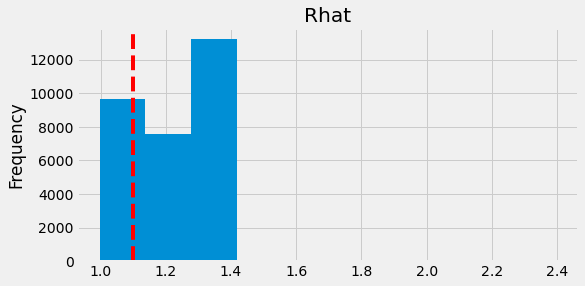

In [17]:
r_hat = summary_stan_fit['Rhat']
r_hat.plot.hist(title="Rhat")
plt.axvline(1.1, color='r', linestyle='--')

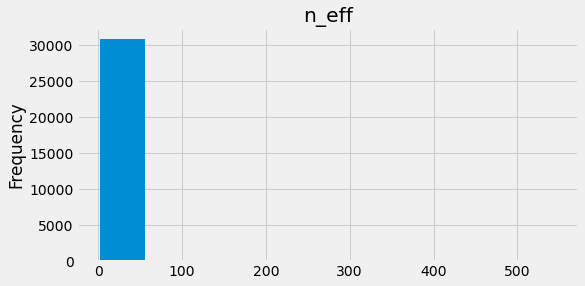

In [18]:
summary_stan_fit['n_eff'].plot.hist(title="n_eff")

In [19]:
stan_utility.utils.check_treedepth(fit_mbi)

2000 of 2000 iterations saturated the maximum tree depth of 10 (100.0%)
  Run again with max_treedepth set to a larger value to avoid saturation


In [20]:
stan_utility.utils.check_energy(fit_mbi)

E-BFMI indicated no pathological behavior


In [21]:
stan_utility.utils.check_div(fit_mbi)

0.0 of 2000 iterations ended with a divergence (0.0%)


### 2.5.2  Effectiveness of Intervention

Here we address the first study question, which we recall is "*Was the mindset intervention effective in improving student achievement?*" This relates to the *Average Treatment Effect (ATE)*. We plot the estimated finite sample ATE below. 

In [25]:
taus = summary_stan_fit.loc[['tau_fs', 'tau']]
taus
#az.plot_density(inf_data, var_names = ["tau", "tau_fs"], 
#                hdi_prob =.95, hdi_markers='v', shade =.5)

#summary_df_cov = summary_df.iloc[1:X[main_cols + inter_cols].shape[1]+1,:] 
#summary_df_cov = summary_df_cov.rename(index=dict(zip(summary_df_cov.index,
#                                                      main_cols + inter_cols)))
#summary_df_cov


#az.plot_density(inf_data, var_names = ["beta_inter"], figsize=(20, 20),
#                hdi_prob =.95, hdi_markers='v', shade =.5)


#az.plot_density(inf_data, var_names = [ "beta"], figsize=(20, 20),
#                hdi_prob =.95, hdi_markers='v', shade =.5)


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
tau_fs,0.169175,0.600753,2.436009,-5.279981,-1.173334,0.486533,1.841948,4.165661,16.442448,1.295591
tau,0.111171,1.070417,4.340747,-9.590881,-2.284636,0.669629,3.087347,7.222047,16.444573,1.295554


# References <a class="anchor" id="ref"></a>

Yeager, D.S., Hanselman, P., Walton, G.M. et al. A national experiment reveals where a growth mindset improves achievement. Nature 573, 364–369 (2019). https://doi.org/10.1038/s41586-019-1466-y

Carvalho, C., Feller, A., Murray, J., Woody, S., and Yeager, D. Assessing Treatment Effect Variation in Observational Studies: Results from a Data Challenge, (2019). https://arxiv.org/abs/1907.07592

Hansen, Ben B. The Prognostic Analogue of the Propensity Score. Biometrika 95 (2), 481–88, (2008). https://doi.org/10.1093/biomet/asn004.

Yeager, D.S., Hanselman, P., Walton, G.M. et al. A national experiment reveals where a growth mindset improves achievement. Nature 573, 364–369 (2019). https://doi.org/10.1038/s41586-019-1466-y


Hahn, P.R., Murray, J.S., Carvalho, C.M. Bayesian Regression Tree Models for Causal Inference: Regularization, Confounding, and Heterogeneous Effects (with Discussion). Bayesian Analysis. 15 (3) 965 - 1056 (2020). https://doi.org/10.1214/19-BA1195

